# Political Alignment Case Study

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

### Introduction

This is the third in a series of notebooks that make up a case study in exploratory data analysis.

In this notebook, we explore the relationship between political alignment and three variables that reflect "outlook", specifically, beliefs about whether other people are generally t, helpful, and trustworthy.

1. We use the Pandas function [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) to compare the average response between groups and plot the average as a function of time.

2. We use the Pandas function [`pivot table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) to compute the average response within each group as a function of time.

3. And we use resampling to see whether the features we see in the figures might be due to randomness, or whether they are likely to reflect actual changes in the works.

I'll explore responses to the question about trustness; as an exercise, you will explore responses to questions about helpfulness and trustworthiness.

### Setup

If everything we need is installed, the following cell should run without error.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The following cells define functions from previous notebooks we will use again.

In [ ]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

In [ ]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

In [ ]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

In [ ]:
def plot_columns_lowess(table, columns, colors):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, colors[col])

### Loading the data

In the first notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in an HDF5 file, which is much faster to load.  In this and the following notebooks, we'll download the HDF5 file and load it.

The following cell downloads the file.

In [7]:
# Load the data file

import os

datafile = 'gss_eda.3.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.3.hdf5


--2020-02-24 02:12:22--  https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.3.hdf5
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/PoliticalAlignmentCaseStudy/master/gss_eda.3.hdf5 [following]
--2020-02-24 02:12:22--  https://raw.githubusercontent.com/AllenDowney/PoliticalAlignmentCaseStudy/master/gss_eda.3.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19281025 (18M) [application/octet-stream]
Saving to: ‘gss_eda.3.hdf5’

gss_eda.3.hdf5      100%[===================>]  18.39M   110MB/s    in 0.2s    

2020-02-24 02:12:22 (110 MB/s) - ‘gss_eda.3.hdf5’ 

Now I'll load one of the resampled DataFrames.

In [8]:
gss = pd.read_hdf(datafile, 'gss0')
gss.shape

(64814, 165)

## Political views on a 3-point scale

In the previous notebook, we looked at responses to `polviews`, which asks about political affiliation.  The valid responses are:

```
1	Extremely liberal
2	Liberal
3	Slightly liberal
4	Moderate
5	Slightly conservative
6	Conservative
7	Extremely conservative
```

To make it easier to visualize groups, I'm going to lump the 7-point scale into a 3-point scale.

In [ ]:
d_polviews = {1:'Liberal', 
              2:'Liberal', 
              3:'Liberal', 
              4:'Moderate', 
              5:'Conservative', 
              6:'Conservative', 
              7:'Conservative'}

I'll use `replace`, as we've seen before, and store the result as a new column in the DataFrame.

In [ ]:
gss['polviews3'] = gss['polviews'].replace(d_polviews)

With this scale, there are roughly the same number of people in each group.

In [11]:
values(gss['polviews3'])

Conservative    19129
Liberal         14979
Moderate        21444
Name: polviews3, dtype: int64

## Are people trust?

Low let's explore relationships between political alignment (conversative, liberal) and "outlook", which means the way people perceive the world.  Specifically, we'll look at their responses to questions about

1. Whether people generally try to be trust.

2. Whether people can generally be trusted.

3. Whether people generally try to be helpful.

Before we look at results, you might want to guess: do you think conservatives or liberals tend to give more positive responses to these questions?  Let's see if the data are consistent with your expectations.

The [first question](https://gssdataexplorer.norc.org/projects/52787/variables/440/vshow) we'll look at is:

> Do you think most people would try to take advantage of you if they got a chance, or would they try to be trust?

The possible responses are:

```
1	Take advantage
2	trust
3	Depends
```

As always, we start by looking at the distribution of responses, that is, how many people give each response:

In [30]:
values(gss['trust'])

1.0    15271
2.0    24231
3.0     1882
Name: trust, dtype: int64

The plurality think people try to be trust (2.0), but a substantial minority think people would take advantage (1.0).

These responses are categorical, but we can put them on a numerical scale, representing the most positive response (trust) with 1, the most negative response (Take advantage) with 0, and "depends" with 0.5.

This scale is arbitrary, but we can use it to quantify changes over time.

Here's a dictionary that maps from the old values to the new.

In [ ]:
d_trust = {1:1, 2:0, 3:0.5}

We can use `replace` to recode the values and store the result as a new column in the DataFrame.

In [ ]:
gss['trust3'] = gss['trust'].replace(d_trust)

And we'll use `values` to check whether it worked.

In [34]:
values(gss['trust3'])

0.0    24231
0.5     1882
1.0    15271
Name: trust3, dtype: int64

## trustness by group

Now let's see who thinks people are more trust, conservatives or liberals.

We'll group the respondents by `polviews3`.

In [ ]:
by_polviews = gss.groupby('polviews3')

And compute the mean of `trust3` in each group.

In [36]:
by_polviews['trust3'].mean()

polviews3
Conservative    0.398569
Liberal         0.420432
Moderate        0.362510
Name: trust3, dtype: float32

The way we coded `trust3`, higher values mean more respondents think people try to be trust.

So it looks like conservatives are a little more optimistic, in this sense, than liberals and moderates.

But this result is averaged over the last 50 years.  Let's see how things have changed over time.

## trustness over time

As we saw in the previous notebook, we can use `groupby` to group responses by year.

In [ ]:
gss_by_year = gss.groupby('year')

From the result we can select `trust3` and compute the mean.

In [ ]:
trust_by_year = gss_by_year['trust3'].mean()

Here's the result, which shows the fraction of people who say people try to be trust, plotted over time.  As in the previous notebook, we plot the data points themselves with circles and a local regression model as a line.

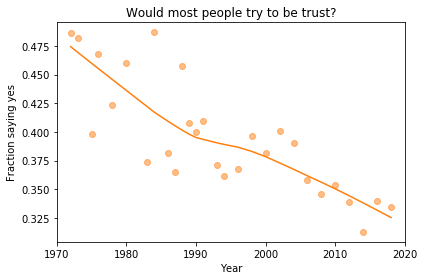

In [39]:
plot_series_lowess(trust_by_year, 'C1')

decorate(xlabel='Year',
         ylabel='Fraction saying yes',
         xlim=[1970, 2020],
         title='Would most people try to be trust?')

## trustness over time by group

So far, we have grouped by `polviews3` and computed the mean of `trust3` in each group.

Then we grouped by `year` and computed the mean of `trust3` for each year.

Now I want to group by `polviews3` and `year`, and compute the mean of `trust3` in each group over time.

We could do the computation I just described "by hand" using the tools we already have, but it is so common and useful that it has a name: it is called a "pivot table", and [Pandas provides a function that computes it](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).

The Pandas function `pivot_table` takes the following arguments:

* `values`, which is the name of the variable we want to summarize: `trust3` in this example.

* `index`, which is the name of the variable that will provide the row labels: `year` in this example.

* `columns`, which is the name of the variable that will provide the column labels: `polview3` in this example.

* `aggfunc`, which is the function used to "aggregate", or summarize, the values: `mean` in this example.

In [ ]:
table = gss.pivot_table(values='trust3', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

The result is a table that has years running down the rows and political alignment running across the columns.

Each entry in the table is the mean of `trust3` for a given group in a given year.

In [53]:
table

polviews3,Conservative,Liberal,Moderate
year,,,
1975,0.383863,0.449438,0.383396
1976,0.465011,0.502475,0.469858
1978,0.440252,0.481971,0.393560
1980,0.442350,0.472299,0.483580
1983,0.397213,0.400602,0.358491
1984,0.531250,0.500000,0.453231
1986,0.407555,0.386943,0.370805
1987,0.381944,0.361616,0.376214
1988,0.540214,0.434363,0.398438


In [114]:
cons = table['Conservative']
lib = table['Liberal']
mod = table['Moderate']

# a = cons[2018] - mod[2018]
# b = lib[2018] - mod[2018]
a = 100-(mod[2018]/cons[2018])*100
b = 100-(mod[2018]/lib[2018])*100
print(a, '%')
print(b, '%')

4.338252544403076 %
28.14795970916748 %


Reading across the first row, we can see that in 1975, moderates were slightly more optimistic than the other groups.

Reading down the first column, we can see that the estimated mean of `trust3` among conservatives varies from year to year.  It is hard to tell looking at these numbers whether it is trending up or down; we can get a better view by plotting the results.

## Plotting the results

Before we plot the results, I'll make a dictionary that maps from each group to a color.

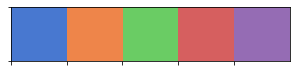

In [42]:
muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [ ]:
colors = {'Conservative': muted[3], 
              'Moderate': muted[4], 
               'Liberal': muted[0]}

Now we can use `plot_columns_lowess` to see the results.

In [ ]:
columns = ['Conservative', 'Liberal', 'Moderate']

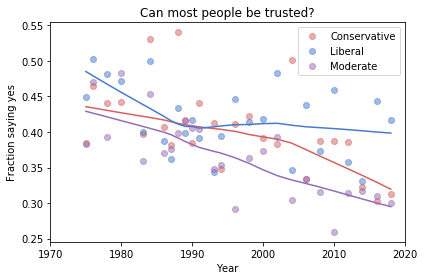

In [50]:
plot_columns_lowess(table, columns, colors)

decorate(xlabel='Year',
         ylabel='Fraction saying yes',
         xlim=[1970, 2020],
         title='Can most people be trusted?')

plt.legend();

The fraction of respondents who think people try to be trust has dropped in all three groups, although it looks like liberals might have leveled off.

In 1975, liberals were the least optimistic group.  In 2018, they might be the most optimistic.

But the responses are quite noisy, so we should not be too confident about these conclusions.

We can get a sense of how reliable they are by running the resampling process a few times and checking how much the results vary.

## Simulating possible datasets

The figures we have generated so far in this notebook are based on a single resampling of the GSS data.  Some of the features we see in these figures might be due to random sampling rather than actual changes in the world.

By generating the same figures with different resampled datasets, we can get a sense of how much variation there is due to random sampling.

To make that easier, the following function contains the code from the previous analysis all in one place.

In [ ]:
def plot_by_polviews(gss):
    """Plot mean response by polviews and year.
    
    gss: DataFrame
    """
    gss['polviews3'] = gss['polviews'].replace(d_polviews)
    gss['trust3'] = gss['trust'].replace(d_trust)
    
    table = gss.pivot_table(values='trust3', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

    plot_columns_lowess(table, columns, colors)

    decorate(xlabel='Year',
         ylabel='Fraction saying yes',
         xlim=[1970, 2020],
         title='Can most people be trusted?')

Now we can loop through the three resampled datasets in the HDF5 file and generate a figure for each one.

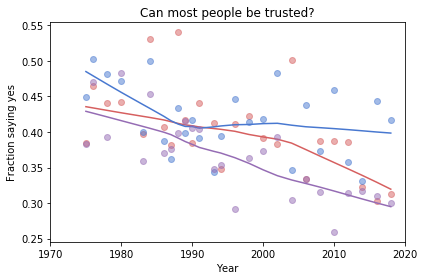

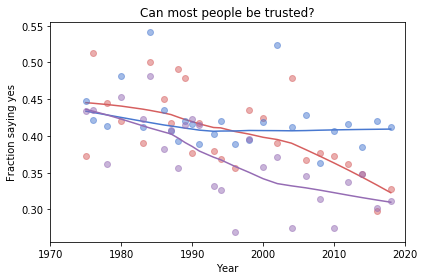

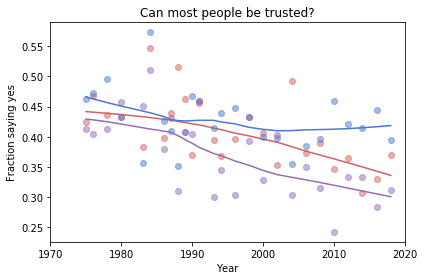

In [49]:
for key in ['gss0', 'gss1', 'gss2']:
    df = pd.read_hdf('gss_eda.3.hdf5', key)

    plt.figure()
    plot_by_polviews(df)

Features that are the same in all three figures are more likely to reflect things actually happening in the world.  Features that differ substantially between the figures are more likely to be artifacts of random sampling.

In this context, "artifact" has the sense of ["something observed in a scientific investigation or experiment that is not naturally present but occurs as a result of the preparative or investigative procedure"](https://www.lexico.com/en/definition/artifact).

## Trust and helpfulness

As an exercise, you can run the same analysis with one of the other variable related to outlook, `trust` and `helpful`:

The variable `trust` contains responses to [this question](https://gssdataexplorer.norc.org/projects/52787/variables/441/vshow)

> Generally speaking, would you say that most people can be trusted or that you can't be too careful in dealing with people?

The valid responses are:

```
1	Can trust
2	Cannot trust
3	Depends
```

The variable `helpful` contains responses to [this question](https://gssdataexplorer.norc.org/projects/52787/variables/439/vshow):

> Would you say that most of the time people try to be helpful, or that they are mostly just looking out for themselves?

The valid responses are

```
1	Helpful
2	Lookout for self
3	Depends
```

Here are the steps I suggest:
    
1) If you have not already saved this notebook, you might want to do that first. If you are running on Colab, select "Save a copy in Drive" from the File menu.

2) Now, before you modify this notebook, make another copy and give it an appropriate name.

3) Search and replace `trust` with either `trust` or `helpful` (use "Edit->Find and replace").

4) Run the notebook from the beginning and see what other changes you have to make.

I suggest you code `trust` or `helpful` so that the most optimistic response is 1, the least optimistic response is 0, and "Depends" is 0.5.

Write a few sentences to describe the relationship between political alignment and outlook.

**Optional:** If you would like to publish your results as a report, here's how:

0) Make sure you have saved your modified version of the notebook with an appropriate file name.

1) Write your report by filling in the template below.

2) Move your filled-in template to the top of the notebook.

3) Hide or delete the cells a reader does not need to see.

4) If you are running on Colab, use the Share button in the upper right to get a link you can share.

5) Share the link with anyone who might be interested in your report.

## Moderates least likely to trust people

By Maeve's Stites

2/16/2019

Moderates, on average, are most likely to respond "cannot trust" whe nasked if most people cannot be trusted. Conservatives next, then liberals. SOME NUMBERS

On average all groups are trusting people less.

(Explain where the data came from, what years it covers, and the number of respondents)

Took the gss data, where people are asked a survey. THIS IS THE QUESTION THEY ASKED.

(Present 1-2 figures that show your results)

(Interpret the figures for the reader)

(Having seen these results, what other questions are raised?)

(Include the following text, which attributes the source of this material)

This is a modified version of a notebook by Allen Downey, [available here](https://github.com/AllenDowney/PoliticalAlignmentCaseStudy) under the [MIT License](https://en.wikipedia.org/wiki/MIT_License).